In [1]:
!pip install -q datasets transformers
!pip install -qU accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.1 MB/s eta 0:00:00


In [2]:
import datasets
data = datasets.load_dataset('jamescalam/image-text-demo', split='train')
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/21 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'image'],
    num_rows: 21
})

In [6]:
from transformers import CLIPProcessor, CLIPModel
model_id = model_id = "openai/clip-vit-base-patch32"
tokenizer = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [7]:
text = data['text']
tokens = tokenizer(text=text, padding=True, images=None, return_tensors='pt')

In [22]:
text_emb = model.get_text_features(**tokens)

In [23]:
print(text_emb.shape)
print(text_emb.min(), text_emb.max())

torch.Size([21, 512])
tensor(-1.1893, grad_fn=<MinBackward1>) tensor(4.8015, grad_fn=<MaxBackward1>)


In [24]:
import numpy as np
text_emb = text_emb.detach().cpu().numpy()
norm_factor = np.linalg.norm(text_emb, axis=1)
norm_factor.shape

(21,)

In [25]:
text_emb = text_emb.T / norm_factor
text_emb = text_emb.T
print(text_emb.shape)
print(text_emb.min(), text_emb.max())

(21, 512)
-0.15268457 0.534499


In [28]:
image_batch = data['image']
images = tokenizer(
    text=None,
    images=image_batch,
    return_tensors='pt'
)['pixel_values']
images.shape

torch.Size([21, 3, 224, 224])

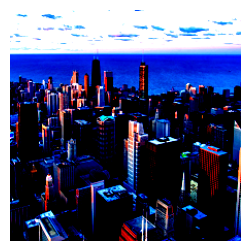

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', figsize=(4, 3))
img = images[1].permute(1, 2, 0)
plt.axis('off')
plt.imshow(img);

In [33]:
img_emb = model.get_image_features(images)
print(img_emb.shape)
print(img_emb.min(), img_emb.max())

torch.Size([21, 512])
tensor(-8.6561, grad_fn=<MinBackward1>) tensor(2.6768, grad_fn=<MaxBackward1>)


In [35]:
img_emb = img_emb.detach().cpu().numpy()
img_emb = img_emb.T / np.linalg.norm(img_emb, axis=1)
img_emb = img_emb.T
print(img_emb.shape)
print(img_emb.min(), img_emb.max())

(21, 512)
-0.7277219 0.2359628


In [38]:
from numpy.linalg import norm
cos_sim = np.dot(text_emb, img_emb.T) / (norm(text_emb, axis=1) * norm(img_emb, axis=1))
cos_sim.shape

(21, 21)

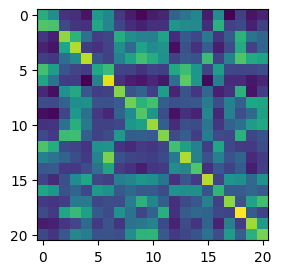

In [40]:
plt.imshow(cos_sim)
plt.show()

(21, 21)


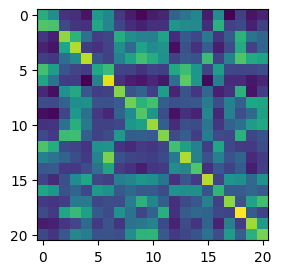

In [41]:
dot_sim = np.dot(text_emb, img_emb.T)
print(dot_sim.shape)
plt.imshow(dot_sim);